In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
import pickle
from PIL import Image
from tensorboardX import SummaryWriter

In [2]:
# for CRNN
class Dataset_CRNN(data.Dataset):
    "Characterizes a dataset for PyTorch"
    def __init__(self, data_path, transform=None):
        "Initialization"
        self.transform = transform
        #self.frames = frames
        self.folders = data_path
        self.frames = 10 #For our case since we are computing 10 frames always

    def __len__(self):
        "Denotes the total number of samples"
        return len(os.listdir(self.folders))

    def read_images(self, data_path, use_transform):
        X = []
        for i in os.listdir(data_path):
            #print("file name is ",i)
            image = Image.open(os.path.join(data_path,i))
            
            #print(image.shape)
            if use_transform is not None:
                image = use_transform(image)
                #print(image.size)
            image = torch.from_numpy(np.asarray(image))
            X.append(image)
        X = torch.stack(X, dim=0)

        return X

    def __getitem__(self, index):
        data_path = os.path.join(self.folders,os.listdir(self.folders)[index])
              
        # Load data
        X = self.read_images(data_path, self.transform)                     # (input) spatial images
        
        y = np.ones(self.frames)
        if 'orig' in data_path:
            y = np.zeros(self.frames)
        # print(X.shape)
        return X, torch.from_numpy(y).type(torch.LongTensor)  #torch.from_numpy(y).type(torch.LongTensor) 

In [3]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    #transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         #std=[0.229, 0.224, 0.225] )
    ])

In [4]:
train_path = '/home/chinmay/datatset/train/'
train_data = Dataset_CRNN(train_path, transform=TRANSFORM_IMG)
# for step, (x, y) in enumerate(data):
#     print(x.shape)
val_path = '/home/chinmay/datatset/val/'
val_data = Dataset_CRNN(val_path, transform=TRANSFORM_IMG)

In [5]:
def new_output_shape(num_of_maxpool_2,shape):
    return int(shape/(2**num_of_maxpool_2))

In [6]:
print(new_output_shape(4,256))

16


In [7]:
# class Meso4(nn.Module):
#     def __init__(self,in_channel=3, img_shape = 256, number_of_classes=1):
#         super(Meso4,self).__init__()
#         self.conv1 = nn.Conv2d(in_channel,8, kernel_size=(3,3), stride = 1, padding= 1)
#         self.batch_norm_1 = nn.BatchNorm2d(8)
#         self.relu = nn.ReLU()
#         self.conv2 = nn.Conv2d(8,8, kernel_size=(5,5),stride=1, padding=2)
#         self.batch_norm_2 = nn.BatchNorm2d(8)
#         self.conv3 = nn.Conv2d(8,16, kernel_size=(5,5),stride=1, padding=2)
#         self.batch_norm_3 = nn.BatchNorm2d(16)
#         self.conv4 = nn.Conv2d(16,16, kernel_size=(5,5),stride=1, padding=2)
#         self.batch_norm_4 = nn.BatchNorm2d(16)
#         self.max_pool_2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
#         self.max_pool_4 = nn.MaxPool2d(kernel_size=(4, 4), stride=4)
#         out_shape = new_output_shape(num_of_maxpool_2=4, shape = img_shape)
#         self.fc_conv = nn.Conv2d(16,number_of_classes,kernel_size=(out_shape,out_shape))
#         self.dropout = nn.Dropout2d(p=0.2)
#         self.sigmoid = nn.Sigmoid()
        
#     def forward(self,x_3d):
#         cnn_embed_seq = []
#         x_3d = x_3d.permute(0,1,4,2,3)# Required to match shapes
#         x_3d = x_3d.type(torch.cuda.FloatTensor) #Converting to Float Tensor from Byte Tensor
#         for t in range(x_3d.size(1)):
#             x = self.conv1(x_3d[:, t, :, :, :])
#             x = self.batch_norm_1(x)
#             x = self.relu(x)
#             # x = self.dropout(x) Avoid in the first layer
#             # Segment 2
#             x = self.max_pool_2(x)
#             x = self.conv2(x)
#             x = self.batch_norm_2(x)
#             x = self.relu(x)
#             x = self.dropout(x)
#             # Segment 3
#             x = self.max_pool_2(x)
#             x = self.conv3(x)
#             x = self.batch_norm_3(x)
#             x = self.relu(x)
#             #x = self.dropout(x)
#             # Segment 4
#             x = self.max_pool_2(x)
#             x = self.conv4(x)
#             x = self.batch_norm_4(x)
#             x = self.relu(x)
#             x = self.dropout(x)
#             # Going for the last layer
#             x = self.max_pool_2(x)
#             x = self.fc_conv(x)
#             #print("Shape of x is {}".format(x.shape))
#             x = self.sigmoid(x)
#             x = x.view(x.shape[0], -1)
            
#             cnn_embed_seq.append(x)
#         cnn_embed_seq = torch.stack(cnn_embed_seq, dim=0).transpose_(0, 1)
#         return cnn_embed_seq

In [8]:
batch_size = 16
epochs = 80
log_interval = 10
learning_rate = 1e-4

In [9]:
# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu") 
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}
train_loader = data.DataLoader(train_data, **params)
valid_loader = data.DataLoader(val_data, **params)



In [10]:
from Meso4 import Meso4
model = Meso4()
model.cuda()

Meso4(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm_2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm_3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm_4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool_2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (max_pool_4): MaxPool2d(kernel_size=(4, 4), stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc_conv): Conv2d(16, 2, kernel_size=(16, 16), stride=(1, 1))
  (dropout): Dropout2d(p=0.

In [11]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
def find_median(numpy_array = []): #This is expected to take an array of array. So,
    #print("Input array is {}".format(numpy_array))
    output = []
    confidence_scores = []
    for array in numpy_array:
        counts = np.bincount(array)
        output.append(np.argmax(counts))
        # Let us compute the confidence of the scores
        # since frames are independent, our confidence is purely based on the number
        # of frames our model thinks is belonging to a specific category
        # the confidence of individual frame prediction is not taken into consideration
        # and this portion is debatable....
        frame_set_pred = np.sort(counts)[-1]
        confidence = frame_set_pred/sum(counts)
        confidence_scores.append(confidence)
    return torch.from_numpy(np.asarray(output)).type(torch.LongTensor), torch.from_numpy(np.asarray(confidence_scores)).type(torch.FloatTensor)

In [13]:
writer_train = SummaryWriter('/home/chinmay/training-results/mesonet_80/train')
writer_test = SummaryWriter('/home/chinmay/training-results/mesonet_80/test')
save_model_path = "/home/chinmay/model_weights/MesoNet_final/MesoNet80"
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train() #Put the model in training mode
    losses = []
    N_count = 0   # counting total trained sample in one epoch
    scores = []
    #single_iter_loss = []
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device)
        N_count += X.size(0)

        optimizer.zero_grad()
        output = model(X)   # output has dim = (batch,frames, number of classes)
        #print(output)
        #print(y.shape)
        loss_train = 0
        for items in range(output.shape[1]):
            loss = loss_function(output[:,items,:], y[:,items])
            loss_train = loss_train + loss.item()
            #single_iter_loss.append(loss)
            loss.backward(retain_graph=True)
            optimizer.step()
        #print("backward update")
        #loss_batch = np.sum(single_iter_loss)
        #loss_batch.backward(retain_graph=True) #Possible improvement to increase speed
        #optimizer.step()
        
        losses.append(loss_train)

        # to compute accuracy
        y_pred = torch.max(output, 2)[1]  # y_pred != output
        # We take the modal value of all predictions. So,
        y,_ = find_median(y) #score term not very important in training
        y_pred, _ = find_median(y_pred)
        #print("filename is {}".format(file_name))
        #print("prediction is {}".format(y_pred))
        
        step_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
        scores.append(step_score)         # computed on CPU
        #print(step_score)
        

        # show information
                 
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss_train, 100 * step_score))
        
    # we should sum all these losses and then divide by the training batch size
    losses_scalar = np.sum(losses)/ len(train_loader.dataset) 
    return losses_scalar, np.mean(scores)

In [14]:
def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    model.eval()

    test_loss = 0
    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device)

            output = model(X)
            #print("Output shape is {}".format(output.shape))
            #print("Expected shape is {}".format(y.shape))
            for items in range(output.shape[1]):
                loss = loss_function(output[:,items,:], y[:,items])
                test_loss += loss.item()                 # sum up batch loss
            #Predict value
            y_pred = torch.max(output, 2)[1]  # (y_pred != output) get the index of the max log-probability
            # Replace the value with the median value
            y_pred, score = find_median(y_pred)
            y, _ = find_median(y) #score here has no inherent meaning
            
            # print few results
            print("Prediction is {} and score is {}".format(y_pred,score))
            
            # collect all y and y_pred in all batches
            all_y.extend(y)
            all_y_pred.extend(y_pred)

    test_loss /= len(test_loader.dataset)

    # compute accuracy
    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(len(all_y), test_loss, 100* test_score))

    # save Pytorch models of best record
    torch.save(model.state_dict(), os.path.join(save_model_path, 'meso_df_2_epoch{}.pth'.format(epoch + 1)))  # save spatial_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'meso_df_2_optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    

    return test_loss, test_score

In [15]:
#Preload the model weights
#save_model_path = "/home/chinmay/model_weights/MesoNet/MesoNet40"
# model_name = "3dcnn_epoch10.pth"
# PATH = save_model_path+model_name
# model.load_state_dict(torch.load(PATH))

In [16]:
def adjust_learning_rate(optimizer, learning_rate, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 20 epochs"""
    lr = learning_rate * (0.1 ** (epoch // 15))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [17]:
epoch_train_losses = []
epoch_train_scores = []
epoch_test_losses = []
epoch_test_scores = []
for epoch in range(epochs):
    # train, test model
    train_losses, train_scores = train(log_interval, model, device, train_loader, optimizer, epoch)
    epoch_test_loss, epoch_test_score = validation(model, device, optimizer, valid_loader)
    # Reduce learning-rate by a factor of 1/10 after every 10 epochs
    # avoid this step as Adam is being used
    #adjust_learning_rate(optimizer=optimizer, learning_rate=learning_rate, epoch=epoch)
    
    # save results
    writer_train.add_scalar('loss',train_losses,epoch+1)
    writer_train.add_scalar('score',train_scores,epoch+1)
    writer_test.add_scalar('loss',epoch_test_loss,epoch+1)
    writer_test.add_scalar('score',epoch_test_score,epoch+1)
    epoch_train_losses.append(train_losses)
    epoch_train_scores.append(train_scores)
    epoch_test_losses.append(epoch_test_loss)
    epoch_test_scores.append(epoch_test_score)
    #Empty the cache
    torch.cuda.empty_cache()


Train Epoch: 1 [160/1408 (11%)]	Loss: 8.282602, Accu: 50.00%
Train Epoch: 1 [320/1408 (23%)]	Loss: 11.528055, Accu: 37.50%
Train Epoch: 1 [480/1408 (34%)]	Loss: 7.433029, Accu: 50.00%
Train Epoch: 1 [640/1408 (45%)]	Loss: 9.420689, Accu: 43.75%
Train Epoch: 1 [800/1408 (57%)]	Loss: 7.540434, Accu: 37.50%
Train Epoch: 1 [960/1408 (68%)]	Loss: 9.402136, Accu: 43.75%
Train Epoch: 1 [1120/1408 (80%)]	Loss: 7.329023, Accu: 43.75%
Train Epoch: 1 [1280/1408 (91%)]	Loss: 8.019024, Accu: 56.25%
Prediction is tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) and score is tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Prediction is tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) and score is tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Prediction is tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) and score is tensor([0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9000, 1.0000,

Prediction is tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) and score is tensor([1.0000, 0.7000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) and score is tensor([1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.6000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) and score is tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Prediction is tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) and score is tensor([1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 0.8000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000])

Test set (300 samples): Average loss: 0.4571, Accuracy: 51.67%

Train Epoch: 3 [160/1408 (11%)]	Loss: 6.788363, Accu: 50.00%
Train Epoch: 3 [320/1408 (23%)]	Loss: 6.744480, Accu: 68.75%
Train Epoch: 

Prediction is tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]) and score is tensor([1.0000, 1.0000, 0.7000, 0.8000, 0.6000, 1.0000, 1.0000, 1.0000, 0.8000,
        1.0000, 1.0000, 0.8000, 0.9000, 0.9000, 0.5000, 0.5000])
Prediction is tensor([1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]) and score is tensor([1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 0.7000, 0.9000, 0.9000, 0.7000,
        0.8000, 1.0000, 0.9000, 1.0000, 1.0000, 0.8000, 0.8000])
Prediction is tensor([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1]) and score is tensor([0.9000, 0.6000, 0.5000, 1.0000, 1.0000, 0.7000, 0.7000, 1.0000, 0.9000,
        1.0000, 0.5000, 1.0000, 0.9000, 0.8000, 0.9000, 1.0000])
Prediction is tensor([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0]) and score is tensor([0.7000, 0.6000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 0.5000,
        0.7000, 0.5000, 0.7000, 0.6000, 1.0000, 0.9000, 0.6000])
Prediction is tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]) and score is 

Prediction is tensor([0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1]) and score is tensor([0.9000, 0.7000, 1.0000, 0.9000, 1.0000, 0.9000, 1.0000, 0.7000, 0.7000,
        0.7000, 1.0000, 0.7000, 1.0000, 0.8000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1]) and score is tensor([0.6000, 1.0000, 1.0000, 0.9000, 0.5000, 1.0000, 0.8000, 0.7000, 0.8000,
        1.0000, 1.0000, 0.9000, 0.6000, 1.0000, 0.6000, 0.9000])
Prediction is tensor([0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1]) and score is tensor([0.8000, 0.9000, 0.7000, 0.9000, 0.7000, 0.6000, 1.0000, 1.0000, 1.0000,
        0.6000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]) and score is tensor([0.6000, 0.9000, 0.9000, 1.0000, 0.9000, 1.0000, 0.8000, 1.0000, 1.0000,
        0.5000, 0.5000, 0.8000, 1.0000, 0.5000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0]) and score is 

Train Epoch: 8 [160/1408 (11%)]	Loss: 6.406941, Accu: 62.50%
Train Epoch: 8 [320/1408 (23%)]	Loss: 4.812125, Accu: 75.00%
Train Epoch: 8 [480/1408 (34%)]	Loss: 5.260194, Accu: 81.25%
Train Epoch: 8 [640/1408 (45%)]	Loss: 5.599065, Accu: 68.75%
Train Epoch: 8 [800/1408 (57%)]	Loss: 4.649858, Accu: 87.50%
Train Epoch: 8 [960/1408 (68%)]	Loss: 3.424519, Accu: 93.75%
Train Epoch: 8 [1120/1408 (80%)]	Loss: 4.945367, Accu: 81.25%
Train Epoch: 8 [1280/1408 (91%)]	Loss: 4.931901, Accu: 75.00%
Prediction is tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1]) and score is tensor([0.9000, 1.0000, 1.0000, 0.8000, 0.8000, 1.0000, 0.7000, 0.9000, 1.0000,
        1.0000, 0.9000, 0.6000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]) and score is tensor([0.9000, 1.0000, 1.0000, 1.0000, 0.6000, 0.6000, 1.0000, 1.0000, 1.0000,
        0.7000, 0.8000, 0.7000, 1.0000, 1.0000, 0.6000, 1.0000])
Prediction is tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Prediction is tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]) and score is tensor([0.6000, 0.9000, 1.0000, 0.9000, 0.8000, 0.9000, 0.5000, 1.0000, 1.0000,
        1.0000, 0.8000, 0.7000, 0.8000, 1.0000, 0.8000, 1.0000])
Prediction is tensor([1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 0.9000, 0.9000, 1.0000, 0.6000, 0.6000, 0.9000,
        0.9000, 1.0000, 1.0000, 1.0000, 0.9000, 0.7000, 1.0000])
Prediction is tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]) and score is tensor([1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000,
        0.8000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0]) and score is tensor([0.8000, 1.0000, 0.8000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 0.9000,
        1.0000, 1.0000, 1.0000, 0.9000, 0.8000, 0.8000, 1.0000])
Prediction is tensor([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1]) and score is 

Prediction is tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000])
Prediction is tensor([1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]) and score is tensor([1.0000, 1.0000, 0.6000, 1.0000, 0.9000, 0.6000, 0.8000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.7000, 1.0000, 0.8000, 1.0000, 0.8000])
Prediction is tensor([0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1]) and score is tensor([1.0000, 1.0000, 0.9000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.6000, 0.9000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1]) and score is tensor([1.0000, 1.0000, 0.7000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7000, 1.0000, 0.6000, 0.8000, 0.8000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]) and score is 

Prediction is tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]) and score is tensor([1.0000, 0.8000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6000, 1.0000, 0.6000,
        1.0000, 0.8000, 1.0000, 0.7000, 1.0000, 0.9000, 1.0000])
Prediction is tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1]) and score is tensor([1.0000, 0.9000, 0.7000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 0.8000,
        1.0000, 0.8000, 0.9000, 0.6000, 1.0000, 1.0000, 0.8000])
Prediction is tensor([1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1]) and score is tensor([0.9000, 1.0000, 1.0000, 0.8000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6000,
        1.0000, 0.8000, 0.9000, 1.0000, 1.0000, 0.9000, 1.0000])
Prediction is tensor([1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 0.6000, 0.7000, 0.6000, 1.0000, 0.9000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000, 0.9000])
Prediction is tensor([1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0]) and score is 

Prediction is tensor([0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1]) and score is tensor([0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 0.8000, 0.9000,
        1.0000, 0.8000, 1.0000])

Test set (300 samples): Average loss: 0.2271, Accuracy: 88.00%

Train Epoch: 15 [160/1408 (11%)]	Loss: 2.462786, Accu: 93.75%
Train Epoch: 15 [320/1408 (23%)]	Loss: 2.661532, Accu: 87.50%
Train Epoch: 15 [480/1408 (34%)]	Loss: 3.654175, Accu: 87.50%
Train Epoch: 15 [640/1408 (45%)]	Loss: 1.882451, Accu: 100.00%
Train Epoch: 15 [800/1408 (57%)]	Loss: 3.200673, Accu: 87.50%
Train Epoch: 15 [960/1408 (68%)]	Loss: 3.486517, Accu: 81.25%
Train Epoch: 15 [1120/1408 (80%)]	Loss: 4.408117, Accu: 93.75%
Train Epoch: 15 [1280/1408 (91%)]	Loss: 3.743823, Accu: 87.50%
Prediction is tensor([1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0]) and score is tensor([1.0000, 1.0000, 0.7000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6000, 0.9000])
Prediction is tensor([

Prediction is tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1]) and score is tensor([0.8000, 1.0000, 0.6000, 1.0000, 1.0000, 0.8000, 1.0000, 0.9000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.7000, 0.9000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0]) and score is tensor([1.0000, 1.0000, 0.8000, 0.7000, 0.7000, 0.7000, 0.8000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1]) and score is tensor([0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.7000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 0.7000, 1.0000, 0.9000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7000, 1.0000])
Prediction is tensor([1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1]) and score is 

Prediction is tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 0.6000, 0.8000, 1.0000, 1.0000, 0.9000, 0.6000,
        1.0000, 0.8000, 1.0000, 0.7000, 1.0000, 0.7000, 1.0000])
Prediction is tensor([0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0]) and score is tensor([1.0000, 0.8000, 1.0000, 1.0000, 0.6000, 0.9000, 1.0000, 1.0000, 0.9000,
        1.0000, 1.0000, 0.8000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0]) and score is tensor([0.9000, 1.0000, 1.0000, 1.0000, 0.7000, 0.8000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 0.9000, 0.6000, 1.0000,
        1.0000, 1.0000, 0.7000, 1.0000, 0.7000, 0.9000, 1.0000])
Prediction is tensor([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]) and score is 

Train Epoch: 20 [1120/1408 (80%)]	Loss: 1.604612, Accu: 100.00%
Train Epoch: 20 [1280/1408 (91%)]	Loss: 0.849812, Accu: 100.00%
Prediction is tensor([0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]) and score is tensor([0.9000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000,
        1.0000, 1.0000, 1.0000, 0.6000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1]) and score is tensor([0.9000, 0.9000, 0.9000, 0.9000, 1.0000, 1.0000, 1.0000, 0.6000, 1.0000,
        1.0000, 0.7000, 1.0000, 1.0000, 1.0000, 0.6000, 0.9000])
Prediction is tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]) and score is tensor([0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000,
        1.0000, 1.0000, 0.9000, 0.5000, 1.0000, 1.0000, 0.8000])
Prediction is tensor([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1]) and score is tensor([0.9000, 1.0000, 1.0000, 0.8000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000,
        0.9000, 0.800

Prediction is tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000,
        1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 0.9000, 0.9000])
Prediction is tensor([0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 0.6000, 1.0000, 0.6000, 0.9000, 0.9000, 1.0000,
        0.9000, 1.0000, 0.9000, 1.0000, 0.6000, 0.9000, 1.0000])
Prediction is tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]) and score is tensor([0.9000, 0.9000, 1.0000, 1.0000, 0.7000, 0.5000, 0.8000, 0.7000, 1.0000,
        1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 0.9000, 0.8000])
Prediction is tensor([1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0]) and score is tensor([0.6000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7000, 1.0000, 0.5000, 0.9000,
        0.9000, 1.0000, 0.7000, 1.0000, 0.7000, 1.0000, 0.7000])
Prediction is tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1]) and score is tensor([1.00

Prediction is tensor([1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9000, 0.9000, 0.7000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0]) and score is tensor([0.8000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000,
        0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7000])
Prediction is tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 0.9000, 0.9000, 1.0000, 0.7000, 1.0000, 0.8000,
        0.8000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0]) and score is tensor([0.8000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.7000, 0.9000, 0.9000, 1.0000, 0.7000, 1.0000])
Prediction is tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0]) and score is 

Prediction is tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 0.8000, 0.5000, 0.9000, 0.9000, 0.7000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9000, 0.9000, 1.0000, 0.9000])
Prediction is tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]) and score is tensor([1.0000, 0.5000, 1.0000, 0.5000, 0.8000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000,
        0.7000, 1.0000, 1.0000, 0.8000, 1.0000, 0.6000, 1.0000])
Prediction is tensor([0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1]) and score is tensor([1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 0.6000,
        1.0000, 1.0000, 0.8000, 0.9000, 0.9000, 0.9000, 0.9000])
Prediction is tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]) and score is 

Prediction is tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 0.7000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000,
        1.0000, 1.0000, 0.9000])

Test set (300 samples): Average loss: 0.2322, Accuracy: 84.67%

Train Epoch: 27 [160/1408 (11%)]	Loss: 1.208299, Accu: 100.00%
Train Epoch: 27 [320/1408 (23%)]	Loss: 2.019934, Accu: 100.00%
Train Epoch: 27 [480/1408 (34%)]	Loss: 2.314309, Accu: 100.00%
Train Epoch: 27 [640/1408 (45%)]	Loss: 1.073643, Accu: 100.00%
Train Epoch: 27 [800/1408 (57%)]	Loss: 1.528962, Accu: 100.00%
Train Epoch: 27 [960/1408 (68%)]	Loss: 2.165896, Accu: 87.50%
Train Epoch: 27 [1120/1408 (80%)]	Loss: 2.496364, Accu: 87.50%
Train Epoch: 27 [1280/1408 (91%)]	Loss: 0.912462, Accu: 100.00%
Prediction is tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1]) and score is tensor([1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000,
        1.0000, 0.8000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is ten

Prediction is tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 0.9000, 1.0000, 0.8000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000])
Prediction is tensor([0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 0.8000,
        0.7000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 0.7000, 1.0000, 0.6000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0]) and score is tensor([0.8000, 1.0000, 1.0000, 1.0000, 0.6000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.6000, 1.0000, 1.0000])
Prediction is tensor([1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]) and score is 

Prediction is tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0]) and score is tensor([0.9000, 1.0000, 0.9000, 0.9000, 1.0000, 1.0000, 1.0000, 0.6000, 0.8000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000, 1.0000])
Prediction is tensor([1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]) and score is tensor([1.0000, 0.8000, 1.0000, 1.0000, 0.7000, 1.0000, 1.0000, 0.9000, 1.0000,
        0.6000, 0.9000, 1.0000, 1.0000, 1.0000, 0.6000, 0.9000])
Prediction is tensor([1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 0.6000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.5000, 0.9000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]) and score is tensor([1.0000, 1.0000, 0.9000, 0.7000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.8000, 0.8000, 0.6000, 0.7000, 1.0000, 0.6000])
Prediction is tensor([0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]) and score is 

Train Epoch: 32 [1120/1408 (80%)]	Loss: 1.502711, Accu: 93.75%
Train Epoch: 32 [1280/1408 (91%)]	Loss: 0.775203, Accu: 100.00%
Prediction is tensor([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]) and score is tensor([0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7000,
        1.0000, 0.8000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000])
Prediction is tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]) and score is tensor([0.9000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.7000, 1.0000, 1.0000, 1.0000, 0.6000, 1.0000])
Prediction is tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0]) and score is tensor([0.8000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000,
        0.6000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 0.7000])
Prediction is tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6000, 1.0000, 0.8000,
        1.0000, 1.0000

Prediction is tensor([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.8000, 1.0000, 0.9000, 1.0000, 0.7000])
Prediction is tensor([0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0]) and score is tensor([1.0000, 0.8000, 0.9000, 0.9000, 0.8000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000])
Prediction is tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 0.7000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000])

Test set (300 samples): Average loss: 0.1520, Accuracy: 92.00%

Train Epoch: 34 [160/1408 (11%)]	Loss: 0.436206, Accu: 100.00%
Train Epoch: 34 [320/1408 (23%)]	Loss: 0.992893, Accu: 100.00%
Train Epoch: 34 [480/1408 (34%)]	Loss: 1.513018, Accu: 100.00%
Train Epoch: 34 [640/1408 (45%)]	Loss: 1.365309, Accu: 100.00%
Train Epoch: 34 [800/1408 (57%)]	Loss: 1

Prediction is tensor([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 0.8000, 0.8000, 1.0000, 1.0000,
        1.0000, 0.8000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]) and score is tensor([1.0000, 0.8000, 1.0000, 0.8000, 1.0000, 0.9000, 1.0000, 1.0000, 0.8000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0]) and score is tensor([0.9000, 0.7000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000, 1.0000, 0.9000,
        1.0000, 0.9000, 1.0000, 0.9000, 1.0000, 1.0000, 0.8000])
Prediction is tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1]) and score is tensor([1.0000, 1.0000, 0.9000, 1.0000, 0.8000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7000, 0.6000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0]) and score is 

Prediction is tensor([1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1]) and score is tensor([1.0000, 1.0000, 0.8000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000,
        1.0000, 1.0000, 1.0000, 0.6000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9000, 0.7000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0]) and score is tensor([1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.7000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]) and score is tensor([1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 0.5000,
        1.0000, 0.7000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000])
Prediction is tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]) and score is 

Train Epoch: 39 [160/1408 (11%)]	Loss: 1.008826, Accu: 100.00%
Train Epoch: 39 [320/1408 (23%)]	Loss: 1.183899, Accu: 100.00%
Train Epoch: 39 [480/1408 (34%)]	Loss: 0.710324, Accu: 100.00%
Train Epoch: 39 [640/1408 (45%)]	Loss: 0.479616, Accu: 100.00%
Train Epoch: 39 [800/1408 (57%)]	Loss: 1.777810, Accu: 100.00%
Train Epoch: 39 [960/1408 (68%)]	Loss: 0.836744, Accu: 100.00%
Train Epoch: 39 [1120/1408 (80%)]	Loss: 3.394539, Accu: 87.50%
Train Epoch: 39 [1280/1408 (91%)]	Loss: 1.126433, Accu: 100.00%
Prediction is tensor([1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]) and score is tensor([0.6000, 1.0000, 1.0000, 0.7000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000])
Prediction is tensor([1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]) and score is tensor([1.0000, 0.8000, 1.0000, 1.0000, 0.9000, 0.9000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9000, 0.9000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 0, 1, 1, 

Prediction is tensor([1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1]) and score is tensor([1.0000, 0.7000, 0.5000, 0.6000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000, 0.9000])
Prediction is tensor([1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000])
Prediction is tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]) and score is tensor([0.7000, 0.9000, 0.9000, 1.0000, 1.0000, 0.6000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000])
Prediction is tensor([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 0.7000, 0.7000, 1.0000, 0.9000,
        0.9000, 1.0000, 0.8000, 0.9000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]) and score is tensor([1.00

Prediction is tensor([0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]) and score is tensor([0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.7000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000, 1.0000, 0.7000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7000])
Prediction is tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 0.7000, 0.6000, 0.7000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.8000, 0.8000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]) and score is tensor([1.0000, 0.9000, 0.9000, 0.9000, 1.0000, 1.0000, 0.7000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7000, 1.0000])
Prediction is tensor([1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0]) and score is 

Prediction is tensor([0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]) and score is tensor([1.0000, 0.6000, 0.8000, 0.9000, 0.7000, 0.8000, 1.0000, 1.0000, 0.9000,
        0.9000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.8000, 1.0000, 0.9000, 1.0000, 1.0000, 0.9000])
Prediction is tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1]) and score is tensor([1.0000, 0.7000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]) and score is tensor([1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9000, 0.8000, 1.0000, 1.0000])
Prediction is tensor([1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0]) and score is 

Prediction is tensor([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1]) and score is tensor([1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6000,
        0.8000, 1.0000, 1.0000])

Test set (300 samples): Average loss: 0.1461, Accuracy: 95.67%

Train Epoch: 46 [160/1408 (11%)]	Loss: 0.776701, Accu: 100.00%
Train Epoch: 46 [320/1408 (23%)]	Loss: 0.763846, Accu: 100.00%
Train Epoch: 46 [480/1408 (34%)]	Loss: 1.179488, Accu: 100.00%
Train Epoch: 46 [640/1408 (45%)]	Loss: 1.902881, Accu: 100.00%
Train Epoch: 46 [800/1408 (57%)]	Loss: 0.622187, Accu: 100.00%
Train Epoch: 46 [960/1408 (68%)]	Loss: 0.900017, Accu: 100.00%
Train Epoch: 46 [1120/1408 (80%)]	Loss: 0.802653, Accu: 100.00%
Train Epoch: 46 [1280/1408 (91%)]	Loss: 0.674195, Accu: 100.00%
Prediction is tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.6000, 1.0000, 0.9000])
Prediction is t

Prediction is tensor([0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0]) and score is tensor([1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9000, 0.9000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]) and score is tensor([1.0000, 1.0000, 0.7000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1]) and score is tensor([1.0000, 0.5000, 1.0000, 0.6000, 1.0000, 0.9000, 0.8000, 1.0000, 1.0000,
        0.8000, 1.0000, 0.9000, 0.9000, 1.0000, 0.9000, 0.9000])
Prediction is tensor([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]) and score is tensor([1.0000, 0.5000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 0.9000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000])
Prediction is tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1]) and score is 

Prediction is tensor([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.8000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 0.6000, 0.9000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0]) and score is tensor([0.8000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 0.6000, 1.0000, 0.9000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.6000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]) and score is tensor([1.0000, 1.0000, 0.5000, 0.8000, 0.8000, 1.0000, 0.8000, 0.9000, 1.0000,
        0.6000, 1.0000, 0.9000, 1.0000, 1.0000, 0.9000, 1.0000])
Prediction is tensor([1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]) and score is 

Train Epoch: 51 [1120/1408 (80%)]	Loss: 0.632793, Accu: 100.00%
Train Epoch: 51 [1280/1408 (91%)]	Loss: 0.522534, Accu: 100.00%
Prediction is tensor([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1]) and score is tensor([1.0000, 0.9000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.6000, 0.9000, 0.9000, 1.0000, 0.6000])
Prediction is tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 0.9000, 0.5000, 1.0000, 0.9000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.8000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 0.8000, 1.0000, 0.6000, 1.0000,
        1.0000, 1.000

Prediction is tensor([0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1]) and score is tensor([0.7000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 0.7000, 1.0000,
        0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0]) and score is tensor([0.7000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 0.8000, 0.7000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.6000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1]) and score is tensor([0.9000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.5000, 0.8000, 0.5000, 0.9000, 1.0000, 1.0000, 0.9000])
Prediction is tensor([0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0]) and score is tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Test set (300 samples): Average loss: 0.1415, Accuracy: 93.67%

Train Epoch: 53 [160/1408 (11%)]	Loss: 0.622571, Accu: 100.00%
Train Epoch: 53 [320/1408 (23%)]	Loss: 0.371354, Accu: 1

Prediction is tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1]) and score is tensor([0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 0.7000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 0.8000, 0.6000])
Prediction is tensor([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 0.9000,
        0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000])
Prediction is tensor([1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1]) and score is tensor([1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]) and score is 

Prediction is tensor([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1]) and score is tensor([0.6000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0]) and score is tensor([1.0000, 0.9000, 0.9000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 0.9000,
        1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 0.9000,
        1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 0.7000, 1.0000])
Prediction is tensor([0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]) and score is tensor([1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000,
        0.6000, 1.0000, 1.0000, 1.0000, 0.6000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0]) and score is 

Train Epoch: 58 [160/1408 (11%)]	Loss: 0.203860, Accu: 100.00%
Train Epoch: 58 [320/1408 (23%)]	Loss: 0.506942, Accu: 100.00%
Train Epoch: 58 [480/1408 (34%)]	Loss: 0.589908, Accu: 100.00%
Train Epoch: 58 [640/1408 (45%)]	Loss: 0.805279, Accu: 100.00%
Train Epoch: 58 [800/1408 (57%)]	Loss: 0.232790, Accu: 100.00%
Train Epoch: 58 [960/1408 (68%)]	Loss: 0.686976, Accu: 100.00%
Train Epoch: 58 [1120/1408 (80%)]	Loss: 0.386314, Accu: 100.00%
Train Epoch: 58 [1280/1408 (91%)]	Loss: 0.377307, Accu: 100.00%
Prediction is tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]) and score is tensor([1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7000, 1.0000, 1.0000,
        1.0000, 0.7000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7000])
Prediction is tensor([0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0]) and score is tensor([1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000,
        0.6000, 1.0000, 0.6000, 1.0000, 1.0000, 1.0000, 0.8000])
Prediction is tensor([1, 0, 0, 1, 1,

Prediction is tensor([1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.8000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0]) and score is tensor([1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 0.8000])
Prediction is tensor([0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]) and score is tensor([0.5000, 1.0000, 1.0000, 0.7000, 1.0000, 1.0000, 1.0000, 0.6000, 1.0000,
        1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000])
Prediction is tensor([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]) and score is tensor([0.6000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7000, 1.0000, 0.6000, 1.0000, 0.8000, 1.0000, 0.6000])
Prediction is tensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1]) and score is tensor([1.00

Prediction is tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]) and score is tensor([1.0000, 1.0000, 0.6000, 0.9000, 1.0000, 0.6000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000])
Prediction is tensor([1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0]) and score is tensor([0.9000, 1.0000, 1.0000, 1.0000, 0.7000, 1.0000, 0.8000, 1.0000, 1.0000,
        1.0000, 0.6000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 0.8000, 0.5000,
        1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7000])
Prediction is tensor([1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0]) and score is tensor([1.0000, 0.6000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6000, 0.9000,
        1.0000, 1.0000, 0.9000, 0.8000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0]) and score is 

Prediction is tensor([1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7000, 1.0000, 1.0000,
        0.7000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 0.7000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 0.8000, 1.0000, 1.0000,
        1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 0.9000, 0.9000])
Prediction is tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1]) and score is tensor([1.0000, 1.0000, 0.9000, 1.0000, 0.7000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.7000, 1.0000, 0.7000, 1.0000, 1.0000, 0.8000])
Prediction is tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0]) and score is 

Prediction is tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0]) and score is tensor([0.8000, 0.8000, 1.0000, 0.9000, 0.9000, 0.8000, 0.8000, 1.0000, 0.9000,
        1.0000, 1.0000, 1.0000])

Test set (300 samples): Average loss: 0.1463, Accuracy: 94.33%

Train Epoch: 65 [160/1408 (11%)]	Loss: 0.397856, Accu: 100.00%
Train Epoch: 65 [320/1408 (23%)]	Loss: 0.235456, Accu: 100.00%
Train Epoch: 65 [480/1408 (34%)]	Loss: 0.462107, Accu: 100.00%
Train Epoch: 65 [640/1408 (45%)]	Loss: 0.414737, Accu: 100.00%
Train Epoch: 65 [800/1408 (57%)]	Loss: 2.091794, Accu: 100.00%
Train Epoch: 65 [960/1408 (68%)]	Loss: 0.031806, Accu: 100.00%
Train Epoch: 65 [1120/1408 (80%)]	Loss: 0.940075, Accu: 100.00%
Train Epoch: 65 [1280/1408 (91%)]	Loss: 0.273795, Accu: 100.00%
Prediction is tensor([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0]) and score is tensor([0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 0.9000, 1.0000, 0.5000,
        1.0000, 0.9000, 1.0000, 1.0000, 0.8000, 1.0000, 1.0000])
Prediction is t

Prediction is tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]) and score is tensor([0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 0.9000,
        0.9000, 1.0000, 1.0000, 0.9000, 1.0000, 0.7000, 1.0000])
Prediction is tensor([1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]) and score is tensor([0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.5000, 1.0000, 1.0000, 0.9000, 1.0000, 0.5000, 1.0000])
Prediction is tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 0.6000, 0.9000, 1.0000, 0.8000, 1.0000, 1.0000,
        0.6000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 0.9000])
Prediction is tensor([0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0]) and score is 

Prediction is tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1]) and score is tensor([0.6000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9000, 0.7000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0]) and score is tensor([0.7000, 0.8000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000, 1.0000])
Prediction is tensor([1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000,
        1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 0.7000, 1.0000])
Prediction is tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1]) and score is tensor([0.6000, 1.0000, 1.0000, 1.0000, 0.9000, 0.8000, 1.0000, 0.8000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0]) and score is 

Train Epoch: 70 [1120/1408 (80%)]	Loss: 0.155945, Accu: 100.00%
Train Epoch: 70 [1280/1408 (91%)]	Loss: 0.482660, Accu: 100.00%
Prediction is tensor([1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]) and score is tensor([1.0000, 1.0000, 0.8000, 1.0000, 1.0000, 1.0000, 0.8000, 0.8000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.6000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1]) and score is tensor([0.6000, 1.0000, 1.0000, 1.0000, 0.7000, 1.0000, 1.0000, 0.9000, 1.0000,
        0.7000, 1.0000, 0.8000, 1.0000, 1.0000, 0.7000, 0.9000])
Prediction is tensor([1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0]) and score is tensor([0.6000, 1.0000, 1.0000, 1.0000, 0.9000, 0.6000, 1.0000, 1.0000, 0.9000,
        1.0000, 1.000

Prediction is tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0]) and score is tensor([0.6000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6000, 0.9000, 0.9000, 1.0000,
        1.0000, 0.9000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]) and score is tensor([1.0000, 0.8000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.8000, 1.0000, 1.0000, 0.8000, 1.0000, 0.9000, 0.9000])
Prediction is tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000, 0.7000, 1.0000, 1.0000,
        0.9000, 1.0000, 1.0000])

Test set (300 samples): Average loss: 0.1261, Accuracy: 95.67%

Train Epoch: 72 [160/1408 (11%)]	Loss: 0.459197, Accu: 100.00%
Train Epoch: 72 [320/1408 (23%)]	Loss: 0.505519, Accu: 100.00%
Train Epoch: 72 [480/1408 (34%)]	Loss: 0.514898, Accu: 100.00%
Train Epoch: 72 [640/1408 (45%)]	Loss: 0.726907, Accu: 100.00%
Train Epoch: 72 [800/1408 (57%)]	Loss: 0

Prediction is tensor([1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0]) and score is tensor([0.7000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000,
        0.6000, 1.0000, 1.0000, 0.7000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0]) and score is tensor([0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 0.8000, 1.0000,
        1.0000, 1.0000, 0.8000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.7000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]) and score is tensor([0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000,
        1.0000, 0.8000, 0.6000, 1.0000, 1.0000, 0.9000, 1.0000])
Prediction is tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]) and score is 

Prediction is tensor([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1]) and score is tensor([1.0000, 1.0000, 0.9000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7000, 0.9000])
Prediction is tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7000, 0.9000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000, 0.7000, 0.7000,
        1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 0.7000, 1.0000])
Prediction is tensor([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000, 1.0000, 0.8000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7000, 1.0000])
Prediction is tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0]) and score is 

Train Epoch: 77 [480/1408 (34%)]	Loss: 0.735490, Accu: 100.00%
Train Epoch: 77 [640/1408 (45%)]	Loss: 0.179150, Accu: 100.00%
Train Epoch: 77 [800/1408 (57%)]	Loss: 0.947900, Accu: 100.00%
Train Epoch: 77 [960/1408 (68%)]	Loss: 0.091565, Accu: 100.00%
Train Epoch: 77 [1120/1408 (80%)]	Loss: 0.425239, Accu: 100.00%
Train Epoch: 77 [1280/1408 (91%)]	Loss: 0.326242, Accu: 100.00%
Prediction is tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000, 1.0000, 1.0000, 0.8000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6000, 1.0000])
Prediction is tensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1]) and score is tensor([1.0000, 0.8000, 0.6000, 1.0000, 0.9000, 0.5000, 0.9000, 1.0000, 0.5000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 0.6000

Prediction is tensor([1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]) and score is tensor([1.0000, 0.5000, 1.0000, 1.0000, 0.6000, 1.0000, 0.9000, 1.0000, 1.0000,
        1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1]) and score is tensor([0.6000, 0.9000, 1.0000, 0.9000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.8000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]) and score is tensor([1.0000, 0.7000, 0.9000, 1.0000, 0.6000, 1.0000, 1.0000, 0.7000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.6000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1]) and score is 

Prediction is tensor([0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1]) and score is tensor([0.9000, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]) and score is tensor([1.0000, 1.0000, 0.7000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000,
        1.0000, 0.6000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]) and score is tensor([1.0000, 1.0000, 1.0000, 0.5000, 0.9000, 1.0000, 0.9000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 0.8000])
Prediction is tensor([0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]) and score is tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9000, 0.9000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction is tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]) and score is 

In [18]:
mean_train_loss = []
for single_epoch in epoch_train_losses:
    mean_train_loss.append(single_epoch/len(train_loader.dataset))
# Same for Train-score
# mean_train_score = []
# for single_epoch in epoch_train_scores:
#     mean_train_score.append(single_epoch/len(train_loader.dataset))

NameError: name 'epoch_train_score' is not defined

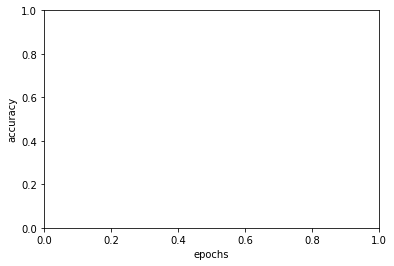

In [19]:
plt.xlabel('epochs')
plt.ylabel('accuracy')

e = np.arange(1, epochs + 1)
plt.plot(e,epoch_train_score)
plt.plot(e,epoch_test_scores)
plt.legend(['train scores', 'validation scores'], loc='upper left')

In [ ]:
plt.xlabel('epochs')
plt.ylabel('loss')

e = np.arange(1, epochs + 1)
plt.plot(e,mean_train_loss)
plt.plot(e,epoch_test_losses)
plt.legend(['train loss', 'validation loss'], loc='upper left')

In [ ]:
save_model_path = "/home/chinmay/model_weights/MesoNet/"
torch.save(model.state_dict(), os.path.join(save_model_path, 'meso_inception_epoch{}.pth'.format(epoch + 1)))  # save spatial_encoder
torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'meso_inception_optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    

In [ ]:
class InceptionLayer(nn.Module):

    def __init__(self, in_channels=3, a=1, b=4, c=4, d=1):
        super(InceptionLayer, self).__init__()
        self.basic_conv_a = nn.Conv2d(in_channels=in_channels, out_channels=a, kernel_size=1)
        self.bn_a = nn.BatchNorm2d(a, eps=0.001)
        # In all these cases, network passes through layer conv1X1 first
        self.basic_conv_b = nn.Conv2d(in_channels=a, out_channels=b, kernel_size=3, padding=1)
        self.bn_b = nn.BatchNorm2d(b, eps=0.001)
        self.basic_conv_c = nn.Conv2d(in_channels=a, out_channels=c, kernel_size=3, padding=2, dilation=2)
        self.bn_c = nn.BatchNorm2d(c, eps=0.001)
        self.basic_conv_d = nn.Conv2d(in_channels=a, out_channels=d, kernel_size=3, padding=3, dilation=3)
        self.bn_d = nn.BatchNorm2d(d, eps=0.001)
        
    def forward(self, x):
        branch1 = self.basic_conv_a(x)
        branch1 = F.relu(self.bn_a(branch1), inplace=True)
        
        branch3_d0 = self.basic_conv_a(x)
        branch3_d0 = self.basic_conv_b(branch3_d0)
        branch3_d0 = F.relu(self.bn_b(branch3_d0), inplace=True)

        branch3_d1 = self.basic_conv_a(x)
        branch3_d1 = self.basic_conv_c(branch3_d1)
        branch3_d1 = F.relu(self.bn_c(branch3_d1), inplace=True)
        
        branch3_d2 = self.basic_conv_a(x)
        branch3_d2 = self.basic_conv_d(branch3_d2)
        branch3_d2 = F.relu(self.bn_d(branch3_d2), inplace=True)
        
        outputs = [branch1, branch3_d0, branch3_d1, branch3_d2]
        return torch.cat(outputs, 1)

In [ ]:
def new_output_shape(num_of_maxpool_2,shape):
    return int(shape/(2**num_of_maxpool_2))

In [ ]:
class Meso_Incepption_v2(nn.Module):
    def __init__(self, in_channels=3, img_shape=256, number_of_classes=1):
        super(Meso_Incepption_v2,self).__init__()
        self.inception_layer_1 = InceptionLayer(in_channels, a=1, b=4, c=4, d=1)
        self.inception_layer_2 = InceptionLayer(in_channels=10, a=1, b=4, c=4, d=2) #First layer had 10 channels
        self.max_pool_2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.max_pool_4 = nn.MaxPool2d(kernel_size=(4, 4), stride=4)
        self.conv_5_1 = nn.Conv2d(in_channels=11, out_channels=16, kernel_size=5, padding=2)#Sum of channels
        self.conv_5_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2)#Sum of channels
        final_h_w = new_output_shape(num_of_maxpool_2=5, shape=img_shape)#We have a MaxPool of 4 included here
        self.fc_conv = nn.Conv2d(16,number_of_classes,kernel_size=(final_h_w,final_h_w))
        
    def forward(self,x_3d):
        cnn_embed_seq = []
        x_3d = x_3d.permute(0,1,4,2,3)# Required to match shapes
        x_3d = x_3d.type(torch.cuda.FloatTensor) #Converting to Float Tensor from Byte Tensor
        for t in range(x_3d.size(1)):
            x1 = self.inception_layer_1(x_3d[:, t, :, :, :])
            x1 = self.max_pool_2(x1)
            # Second layer
            x2 = self.inception_layer_2(x1)
            x2 = self.max_pool_2(x2)
            # Third layer
            x3 = self.conv_5_1(x2)
            x3 = F.relu(self.max_pool_2(x3), inplace=True)
            # Fourth layer
            x4 = self.conv_5_2(x3)
            x4 = F.relu(self.max_pool_4(x4), inplace=True)
            # Now flatten the layers
            x = self.fc_conv(x4)
            #print("Shape of x is {}".format(x.shape))
            x = x.view(x.shape[0], -1)
            
            cnn_embed_seq.append(x)
        cnn_embed_seq = torch.stack(cnn_embed_seq, dim=0).transpose_(0, 1)
        return cnn_embed_seq

In [ ]:
model = Meso_Incepption_v2()
model.cuda()
print("loaded")